In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scorer import scorer
from sklearn.model_selection import train_test_split

import gc

In [13]:
dtypes = {'id1': np.int16, 'id2': np.int16, 'id3': np.int16, 'user_id': np.int32, 'date': np.int16}

train = pd.read_csv('train.csv.zip', dtype=dtypes)

In [14]:
# drop 'inactive' and 'overactive' users 

user_count = np.unique(train.user_id[train.date>(np.max(train.date)-7)], return_counts=True)
user_count = pd.DataFrame({
    'user_id':user_count[0], 'counts':user_count[1]
})

#print(user_count.shape)
treshold_count_low = 8
treshold_count_high = 50
user_count = user_count[(user_count.counts>=treshold_count_low) & (user_count.counts<treshold_count_high)]
user_count = user_count[0:53979]
#print(user_count.shape)

train = pd.merge(train, user_count, how='left', on ='user_id')
train = train.dropna()
#print(train.shape, len(pd.unique(train.user_id)))

user_count = []
gc.collect()

4100

In [15]:
%%time

# make strings with pages that user have visited last 3 weeks 

n_weeks = 3
train_start_date = np.max(train['date']) - 6 - n_weeks*7
train_end_date = np.max(train['date']) - 7
test_start_date = np.max(train['date']) - n_weeks*7
test_end_date = np.max(train['date'])
print(train_start_date, train_end_date, test_start_date, test_end_date)

train['id3'] = train['id3'].astype('str')
strings_test = pd.DataFrame(train[['id3','user_id']][(train['date']>test_start_date) & (train['date']<=test_end_date)].groupby('user_id')['id3'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
strings_train = pd.DataFrame(train[['id3','user_id', 'counts']][(train['date']>train_start_date) & (train['date']<=train_end_date)].groupby('user_id')['id3'].apply(lambda x: "%s" % ' '.join(x))).reset_index()

27 47 33 54
CPU times: user 8.48 s, sys: 136 ms, total: 8.61 s
Wall time: 8.6 s


In [16]:
%%time
train['id3'] = train['id3'].astype('int')
topid3 = train[['id3', 'user_id']].groupby('id3').agg('count').reset_index()
topid3.columns = ['id3', 'id3_counts']

CPU times: user 716 ms, sys: 24 ms, total: 740 ms
Wall time: 739 ms


In [17]:
print(topid3.shape)
topid3 = topid3.sort_values(by='id3_counts', ascending=False).reset_index(drop=True)

(919, 2)


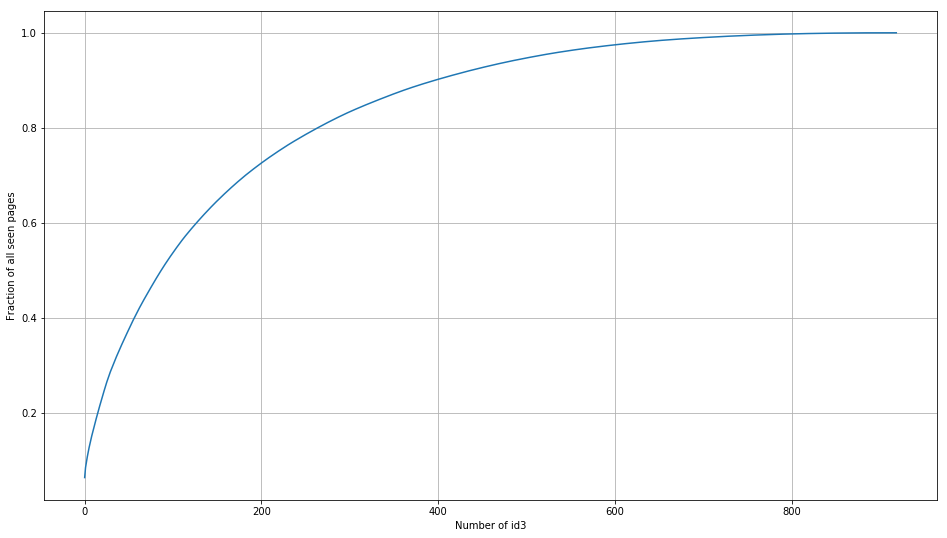

In [18]:
plt.figure(figsize=(16,9))
plt.plot(topid3['id3_counts'].cumsum()/np.sum(topid3['id3_counts']))
plt.xlabel('Number of id3')
plt.ylabel('Fraction of all seen pages')
plt.grid()
plt.show()

In [19]:
select_top_n = 100 # select top_n most popular id3
topid3['keep_id'] = 0
topid3['keep_id'][0:select_top_n] = 1
topid3 = topid3[0:select_top_n].reset_index(drop=True)
topid3_values = topid3['id3'].values
print(topid3.shape)

(100, 3)


In [20]:
print(train.shape, len(pd.unique(train.user_id)))
train = pd.merge(train, topid3, how='left', on ='id3')
train = train[train['keep_id']==1].reset_index(drop=True)
print(train.shape, len(pd.unique(train.user_id)))

(6883678, 6) 53979
(3681615, 8) 53924


In [21]:
topid3 = topid3.drop('keep_id', axis=1)
topid3['id3_counts'] = topid3['id3_counts'] / np.sum(topid3['id3_counts'])

In [22]:
dtypes = {'id1': np.int16, 'id2': np.int16, 'id3': np.int16, 'user_id': np.int32, 'date': np.int16}

train = pd.read_csv('train.csv.zip', dtype=dtypes)
ind_list = np.load('ind_list.npy')
train = train[train['user_id'].isin(ind_list)].copy()

## generate targets and forbid targets 

In [23]:
date_validation_start = train.date.max() - 6
def calculate_target(data, date_test_start):
    '''
        This function returns a dictionary of type {user: items_list}
        Such that user viewed an item in testing period, 
        but did not view it within the last 3 weeks of train period.
    '''
    
    test_mask = (data.date >= date_test_start) & (data.date < date_test_start + 7)
    items_test = data[test_mask].groupby('user_id').id3.apply(set)

    return items_test

y_val_dict = calculate_target(train, date_validation_start)

In [24]:
len(y_val_dict)

6412

In [25]:
%%time
k = y_val_dict.keys()
gen_zero = {} # '0' examples, i.e. it will not been visited next week 
tot_lens = []
number_neg_examples_to_pick = 50

for i in k:
    pick = set(np.random.choice(topid3['id3'], p=topid3['id3_counts'], 
                                       size = number_neg_examples_to_pick, replace=False)) - y_val_dict[i]
    gen_zero[i] = pick
    tot_lens.append(len(pick))

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


In [26]:
%%time 
values_list = []
keys_list = []
for k,v in y_val_dict.items():
    values_list += v
    keys_list += [k] * len(v)
target = pd.DataFrame({'user_id': keys_list, 'target' : values_list})  # '1' examples, i.e. it will been visited next week 
# target.to_csv('target.csv', index=False)

print(target.shape)

(127880, 2)
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 31.9 ms


In [27]:
%%time 
values_list = []
keys_list = []
for k,v in gen_zero.items():
    values_list += v
    keys_list += [k] * len(v)
gen_zero = pd.DataFrame({'user_id': keys_list, 'target' : values_list})
# gen_zero.to_csv('target0.csv', index=False)

print(gen_zero.shape)

(280934, 2)
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 103 ms


In [28]:
target['clicked'] = 1
gen_zero['clicked'] = 0
target = pd.concat([target, gen_zero]).reset_index(drop=True)

In [29]:
targets = set(pd.unique(train['id3'].astype('int')))

In [30]:
print('Targets to predict: ', len(pd.unique(target.target)))
print(target.shape)

Targets to predict:  903
(408814, 3)


In [31]:
gen_zero.shape

(280934, 3)

## get X_train and X_test 

In [32]:
%%time
target = pd.merge(target, strings_train, on='user_id', how='left')
print(target.shape)
target = target.dropna()
print(target.shape)

(408814, 4)
(197567, 4)
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 68.7 ms


In [33]:
cv = TfidfVectorizer(max_features=100)

In [34]:
%%time
cv.fit(strings_train['id3'].astype('str'))
X_train = cv.transform(target['id3'].astype('str'))
X_test = cv.transform(strings_test['id3'].astype('str'))
print(X_train.shape)

(197567, 100)
CPU times: user 9.33 s, sys: 8 ms, total: 9.34 s
Wall time: 9.34 s


In [35]:
X_train1 = pd.concat([pd.DataFrame(X_train.todense()), target['target']], axis=1)

X_train = []
gc.collect()

X_train1 = pd.concat([X_train1, target['user_id'], target['clicked']], axis=1)

print('users in train', len(pd.unique(X_train1['user_id'])))

print(X_train1.shape)
X_train1 = X_train1.dropna()
print(X_train1.shape)

X_train1 = X_train1.sort_values(by='user_id').reset_index(drop = True)
query = X_train1[['user_id', 'target']].groupby('user_id').agg('count').reset_index()[['user_id','target']]

users in train 3236
(285590, 103)
(109544, 103)


In [36]:
iid = X_train1.user_id[-int(X_train1.shape[0]/5):-int(X_train1.shape[0]/5)+1].values[0] # 20% of user_id in validation

train_data = lgb.Dataset( 
    X_train1[X_train1['user_id']<=iid].drop(['clicked','user_id'],axis=1), 
    label = X_train1['clicked'][X_train1['user_id']<=iid], 
    categorical_feature=['target'],
    free_raw_data=False,
    group = query[query['user_id']<=iid]['target'].values
)

valid_data = lgb.Dataset( 
    X_train1[X_train1['user_id']>iid].drop(['clicked','user_id'],axis=1), 
    label = X_train1['clicked'][X_train1['user_id']>iid], 
    categorical_feature=['target'],
    free_raw_data=False,
    group = query[query['user_id']>iid]['target'].values
)


#params = {
 #   'objective':'binary',
  #  'metric': 'binary_logloss',
   # 'learning_rate':0.1142,
   # 'random_state':4242
#}


In [37]:
params = {
        'objective' : 'lambdarank',
        'metric' : 'ndcg',
        'ndcg_at' : 10,
        "boosting_type": "goss",
        'learning_rate' : 0.22,
        'verbose' : 1,
        'random_state': 4242,
        # 'num_leaves': # default - 31
        # 'bagging_freq':    
    'max_position':45 # default = 20
    }

In [38]:
%%time
model = lgb.train(params, train_data, num_boost_round=1500, 
                  valid_sets=valid_data, early_stopping_rounds=50)

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's ndcg@10: 1
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's ndcg@10: 1
[3]	valid_0's ndcg@10: 1
[4]	valid_0's ndcg@10: 1
[5]	valid_0's ndcg@10: 1
[6]	valid_0's ndcg@10: 1
[7]	valid_0's ndcg@10: 1
[8]	valid_0's ndcg@10: 1
[9]	valid_0's ndcg@10: 1
[10]	valid_0's ndcg@10: 1
[11]	valid_0's ndcg@10: 1
[12]	valid_0's ndcg@10: 1
[13]	valid_0's ndcg@10: 1
[14]	valid_0's ndcg@10: 1
[15]	valid_0's ndcg@10: 1
[16]	valid_0's ndcg@10: 1
[17]	valid_0's ndcg@10: 1
[18]	valid_0's ndcg@10: 1
[19]	valid_0's ndcg@10: 1
[20]	valid_0's ndcg@10: 1
[21]	valid_0's ndcg@10: 1
[22]	valid_0's ndcg@10: 1
[23]	valid_0's ndcg@10: 1
[24]	valid_0's ndcg@10: 1
[25]	valid_0's ndcg@10: 1
[26]	valid_0's ndcg@10: 1
[27]	valid_0's ndcg@10: 1
[28]	valid_0's ndcg@10: 1
[29]	valid_0's ndcg@10: 1
[30]	valid_0's ndcg@10: 1
[31]	valid_0's ndcg@10: 1
[32]	valid_0's ndcg@10: 1
[33]	valid_0's ndcg@10: 1
[34]	valid_0's ndcg@10: 1
[35]	valid_0's ndcg@10: 1
[36]	valid_0's ndcg@10: 1
[37]	valid_

## validate model 

In [39]:
dfff = pd.DataFrame({})
dfff['where'] = np.arange(0,200)
dfff['acc'] = 0
dfff['seen'] = 0

X_valid = cv.transform(strings_train['id3'].astype('str'))[-strings_train[strings_train.user_id>iid].shape[0]:]
tt = strings_train[strings_train.user_id>iid].reset_index(drop=True)
where_to_check_list = []
acc = 0
checked = 0
for i in range(0, 5000):
    try:
        X_test1 = pd.concat([pd.concat([pd.DataFrame(X_valid[i].todense())]*len(topid3_values), ignore_index=True), pd.DataFrame({'target': topid3_values}, index=range(0,len(topid3_values)))], axis=1)
 
        model_prediction = model.predict(X_test1)
        pred = pd.DataFrame({
        'value': model_prediction,
        'label': topid3_values
        })
        pred = pred.sort_values(by='value', ascending=False)
        forbiden = list(map(int, tt.id3[i].split(' ')))
        fin_pred = [x for x in list(pred['label']) if x not in forbiden][0:5]
        sss = list(pred[pred.label==fin_pred[-1]]['value'])[0]
    
        if (len(fin_pred)<5):
            low = low +1
    
        while (len(fin_pred)<5):
            fin_pred.append(610)
    
        true_values = y_val_dict[tt['user_id'][i]]
        
        where_to_check = np.where(pred.reset_index(drop=True).label==fin_pred[-1])[0][0]  
        where_to_check_list.append(where_to_check)
        
        checked = checked + 1
        print('Users in validation:', i, 'Yandex score:', np.round(acc/(checked+1)*10000))
        
        if (len(set(fin_pred) - true_values)<5):
            acc = acc+1
            dfff['acc'][dfff['where']==where_to_check] = dfff['acc'][dfff['where']==where_to_check] + 1
        dfff['seen'][dfff['where']==where_to_check] = dfff['seen'][dfff['where']==where_to_check] + 1
    
    except:
            pass

Users in validation: 13 Yandex score: 0.0
Users in validation: 24 Yandex score: 3333.0
Users in validation: 41 Yandex score: 5000.0
Users in validation: 44 Yandex score: 4000.0
Users in validation: 72 Yandex score: 5000.0
Users in validation: 112 Yandex score: 5714.0
Users in validation: 152 Yandex score: 5000.0
Users in validation: 154 Yandex score: 4444.0
Users in validation: 155 Yandex score: 4000.0
Users in validation: 166 Yandex score: 3636.0
Users in validation: 174 Yandex score: 4167.0
Users in validation: 182 Yandex score: 4615.0
Users in validation: 185 Yandex score: 4286.0
Users in validation: 213 Yandex score: 4667.0
Users in validation: 228 Yandex score: 5000.0
Users in validation: 233 Yandex score: 5294.0
Users in validation: 236 Yandex score: 5000.0
Users in validation: 241 Yandex score: 4737.0
Users in validation: 245 Yandex score: 5000.0
Users in validation: 246 Yandex score: 5238.0
Users in validation: 253 Yandex score: 5455.0
Users in validation: 257 Yandex score: 565

Users in validation: 2482 Yandex score: 5389.0
Users in validation: 2492 Yandex score: 5359.0
Users in validation: 2497 Yandex score: 5330.0
Users in validation: 2502 Yandex score: 5355.0
Users in validation: 2510 Yandex score: 5380.0
Users in validation: 2532 Yandex score: 5351.0
Users in validation: 2537 Yandex score: 5323.0
Users in validation: 2563 Yandex score: 5294.0
Users in validation: 2564 Yandex score: 5266.0
Users in validation: 2565 Yandex score: 5238.0
Users in validation: 2576 Yandex score: 5263.0
Users in validation: 2584 Yandex score: 5288.0
Users in validation: 2635 Yandex score: 5312.0
Users in validation: 2642 Yandex score: 5285.0
Users in validation: 2670 Yandex score: 5258.0
Users in validation: 2700 Yandex score: 5282.0
Users in validation: 2701 Yandex score: 5255.0
Users in validation: 2705 Yandex score: 5228.0
Users in validation: 2722 Yandex score: 5202.0
Users in validation: 2741 Yandex score: 5176.0
Users in validation: 2742 Yandex score: 5150.0
Users in vali

In [40]:
# where to check model metrics 
np.unique(where_to_check_list, return_counts=True)

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 66]),
 array([24, 46, 47, 50, 43, 35, 16, 15, 20,  9,  9,  7,  4,  2,  1,  1,  1]))

## pred test 

In [41]:
%%time
low = 0
sub = pd.DataFrame({})
min_last = []
# 53979
for i in range(0, X_test.shape[0]):

    X_test1 = pd.concat([pd.concat([pd.DataFrame(X_test[i].todense())]*len(topid3_values), ignore_index=True), pd.DataFrame({'target': topid3_values}, index=range(0,len(topid3_values)))], axis=1)
    model_prediction = model.predict(X_test1)
    pred = pd.DataFrame({
        'value': model_prediction,
        'label': topid3_values
    })
    pred = pred.sort_values(by='value', ascending=False)
    forbiden = list(map(int, strings_test.id3[i].split(' ')))
    fin_pred = [x for x in list(pred['label']) if x not in forbiden][0:5]
    
    if (len(fin_pred)==0):
        sss = 0
    else:
        sss = list(pred[pred.label==fin_pred[-1]]['value'])[0]
    
    if (len(fin_pred)>=1):
        min_last.append(pred['value'][pred.label==fin_pred[-1:]].values[0])
    
    if (len(fin_pred)<5):
        low = low +1
    
    while (len(fin_pred)<5):
        fin_pred.append(610)

    temp_df = pd.DataFrame({
        'user_id': strings_test['user_id'][i],
        'id3_1':int(fin_pred[0]),
        'id3_2':int(fin_pred[1]),
        'id3_3':int(fin_pred[2]),
        'id3_4':int(fin_pred[3]),
        'id3_5':int(fin_pred[4]),
        'last': sss
    }, index = [0])
    sub = pd.concat([sub, temp_df])

CPU times: user 18min 14s, sys: 2.45 s, total: 18min 17s
Wall time: 8min 14s


In [42]:
print(sub.shape)
sub = sub.drop_duplicates()
print(sub.shape)

(53979, 7)
(53979, 7)


In [43]:
sub = sub.sort_values(by='last', ascending=False)

In [44]:
sub[0:53979].head()

,id3_1,id3_2,id3_3,id3_4,id3_5,last,user_id
0,145,640,860,840,554,0.11,130405
0,640,860,840,554,704,0.11,205938
0,700,132,247,554,137,0.11,17373
0,329,311,704,813,392,0.11,181674
0,860,841,554,111,392,0.11,489117


In [45]:
sub.shape

(53979, 7)

In [47]:
sampe_sub = sub[['user_id','id3_1','id3_2','id3_3','id3_4','id3_5']][0:53979]
sampe_sub.to_csv('sample_sub23.csv', index=False)
#  2807 - sample_sub23
#  1411 - sample_sub22
#  2131 - sample_sub21

In [ ]:
sampe_sub.head()

In [46]:
import telepyth # push notif in telegram

%telepyth -t 1260389131217015787
%telepyth 'Very magic, wow!\n' 

Use token 1260389131217015787.


'Very magic, wow!\n'